In [5]:
import numpy as np
import pandas as pd
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Input, Concatenate
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [6]:
df = pd.read_csv('./UCYdemo_2022_2023.csv', parse_dates=[0])
df = df.drop(columns=['GHI', 'Pdc', 'Tmod'])
df.head(200)

/var/folders/gb/sjxj389901n7jtz0mzqvm0xr0000gn/T/ipykernel_13426/1038405271.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./UCYdemo_2022_2023.csv', parse_dates=[0])


,Datetime,Tamb,RH,POA,Pac
0,2022-01-01 00:00:00,15.18,83.3,0.0,0.002
1,2022-01-01 00:30:00,15.04,85.1,0.0,0.002
2,2022-01-01 01:00:00,14.73,86.5,0.0,0.002
3,2022-01-01 01:30:00,14.32,87.2,0.0,0.002
4,2022-01-01 02:00:00,13.98,87.7,0.0,0.002
...,...,...,...,...,...
195,2022-01-05 01:30:00,12.70,86.3,0.0,0.002
196,2022-01-05 02:00:00,12.42,86.3,0.0,0.002
197,2022-01-05 02:30:00,12.16,88.5,0.0,0.002
198,2022-01-05 03:00:00,12.11,85.4,0.0,0.002


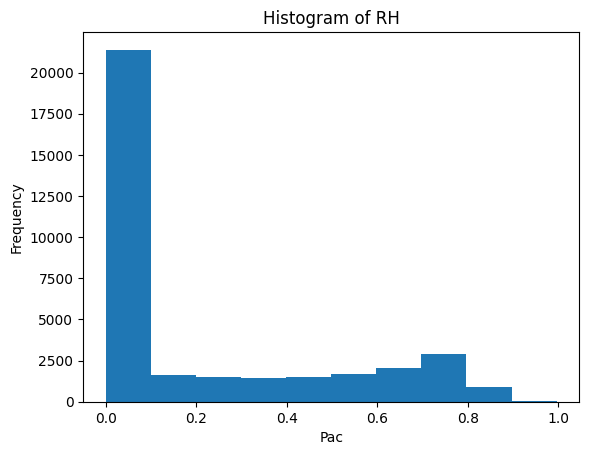

In [7]:

plt.hist(df['Pac'], bins=10)
plt.xlabel('Pac')
plt.ylabel('Frequency')
plt.title('Histogram of RH')
plt.show()

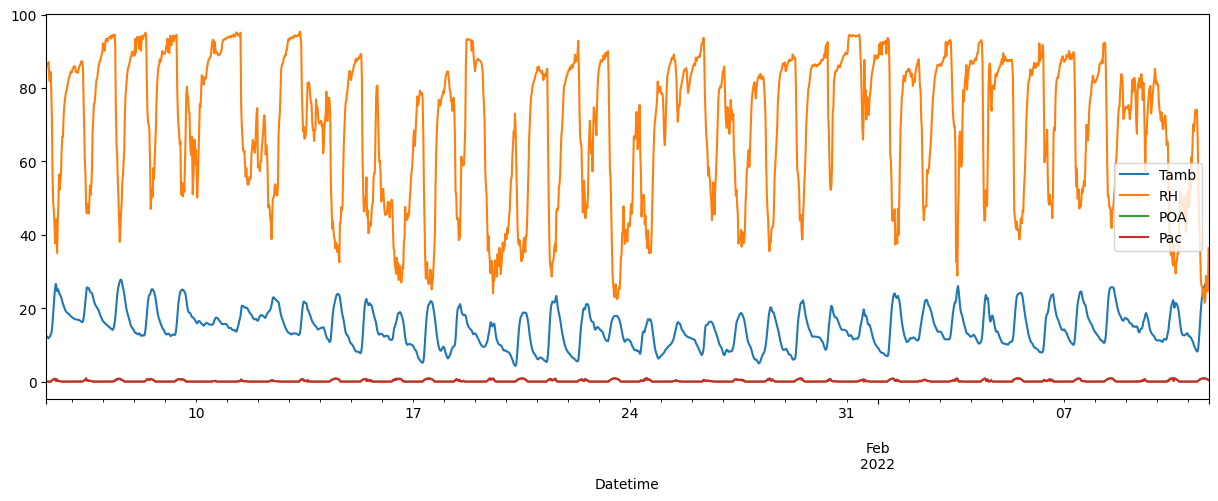

In [8]:
_ = df.loc[200:2000].plot(x='Datetime', style='-', figsize=(15,5))

In [9]:
# Normalize the data


In [10]:
# func to add time series columns
# def create_time_series_columns(df, lag=3, series_columns=['Pac'], label = False):
#     for i in range(1, lag + 1):
#         for col in series_columns:
#             df[f'{col}(t-{i})'] = df[col].shift(i)

In [11]:
# create_time_series_columns(df, lag=4, series_columns=['Pac'])
# df.head(10)

In [16]:
def transform_time_var(var, div: float):
    normalized_var = var / div
    var_sin = np.sin(2 * np.pi * normalized_var)
    var_cos = np.cos(2 * np.pi * normalized_var)
    return var_sin, var_cos

# turn datetime into day, year, month, hour, minute
def datetime_to_columns(df, datetime_column='Datetime'):
    new_df = df.copy()
    new_df['month_sin'], new_df['month_cos'] = transform_time_var(df[datetime_column].dt.month, 12)
    new_df['min_sin'], new_df['min_cos'] = transform_time_var(
        df[datetime_column].dt.hour * 60 + df[datetime_column].dt.minute, 
        1440                # 24 hours * 60 minutes
    )
    
    return new_df

In [17]:
split_date = '01-Jul-2023'
df_train = df.loc[df.Datetime <= split_date].copy()
df_test = df.loc[df.Datetime > split_date].copy()

In [18]:
df_train = datetime_to_columns(df_train, 'Datetime')
df_test = datetime_to_columns(df_test, 'Datetime')

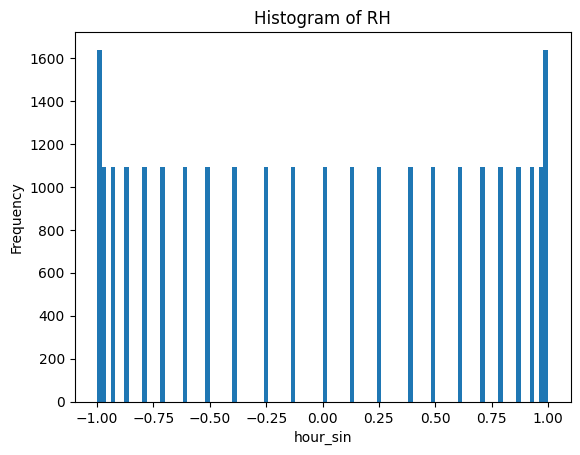

In [19]:
plt.hist(df_train['min_sin'], bins=100)
plt.xlabel('hour_sin')
plt.ylabel('Frequency')
plt.title('Histogram of RH')
plt.show()

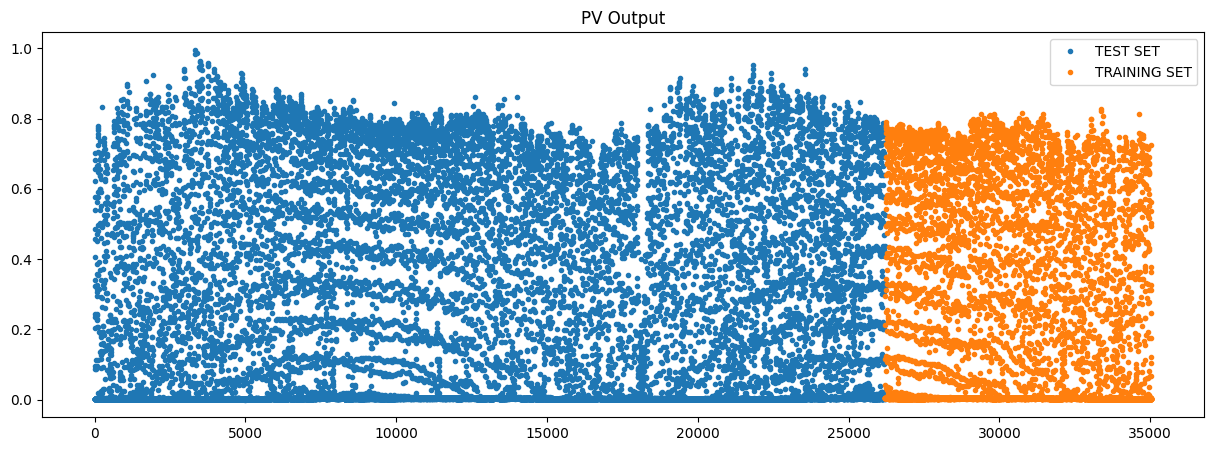

In [20]:
_ = (df_train[['Pac']]
  .rename(columns={'Pac': "TEST SET"}) \
  .join(df_test[["Pac"]].rename(columns={'Pac': 'TRAINING SET'}), how='outer')
  .plot(figsize=(15,5), title="PV Output", style='.')
)

In [21]:
# Func to create train and test data
def create_samples(df, lag, target_column='Pac'):

    X_train = []
    y_train = []
    for i in range(lag, len(df)):
        X_train.append(df.iloc[i-lag:i])
        y_train.append(df[target_column].iloc[i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    print(X_train[0])
    return X_train, y_train

In [22]:

LAG = 10
X_train, y_train = create_samples(df_train.drop(columns=['Datetime']), LAG, target_column='Pac')
X_test, y_test = create_samples(df_test.drop(columns=['Datetime']), LAG, target_column='Pac')

(26199, 10, 8)
[[1.51800000e+01 8.33000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 0.00000000e+00 1.00000000e+00]
 [1.50400000e+01 8.51000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 1.30526192e-01 9.91444861e-01]
 [1.47300000e+01 8.65000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 2.58819045e-01 9.65925826e-01]
 [1.43200000e+01 8.72000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 3.82683432e-01 9.23879533e-01]
 [1.39800000e+01 8.77000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 5.00000000e-01 8.66025404e-01]
 [1.37300000e+01 8.82000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 6.08761429e-01 7.93353340e-01]
 [1.34400000e+01 8.87000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 7.07106781e-01 7.07106781e-01]
 [1.31300000e+01 9.10000000e+01 0.00000000e+00 2.00000000e-03
  5.00000000e-01 8.66025404e-01 7.93353340e-01 6

In [23]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(LAG, X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/alextseng/Documents/ucy-pv-forecasting/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0162
Epoch 2/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050
Epoch 3/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0045
Epoch 4/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0044
Epoch 5/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0043
Epoch 6/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042
Epoch 7/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0042
Epoch 8/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0041
Epoch 9/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0040
Epoch 10/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039
Epoch 11/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0041
Epoch 12/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039
Epoch 13/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0040
Epoch 14/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039
Epoch 15/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [25]:
# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
Mean Squared Error: 0.15505281633113546


In [26]:
with_predicts = df_test[LAG:len(df_test)].copy()

with_predicts['Predictions'] = predictions
with_predicts.head(10)

,Datetime,Tamb,RH,POA,Pac,month_sin,month_cos,min_sin,min_cos,Predictions
26219,2023-07-01 05:30:00,25.24,67.19,0.030,0.005,-0.5,-0.866025,0.991445,1.305262e-01,-0.010716
26220,2023-07-01 06:00:00,25.71,63.91,0.080,0.042,-0.5,-0.866025,1.000000,6.123234e-17,0.002169
26221,2023-07-01 06:30:00,26.94,58.92,0.161,0.117,-0.5,-0.866025,0.991445,-1.305262e-01,0.064414
26222,2023-07-01 07:00:00,28.71,51.00,0.244,0.212,-0.5,-0.866025,0.965926,-2.588190e-01,0.195939
26223,2023-07-01 07:30:00,30.36,44.17,0.333,0.296,-0.5,-0.866025,0.923880,-3.826834e-01,0.318763
26224,2023-07-01 08:00:00,32.08,39.20,0.445,0.405,-0.5,-0.866025,0.866025,-5.000000e-01,0.398686
26225,2023-07-01 08:30:00,33.78,31.49,0.546,0.495,-0.5,-0.866025,0.793353,-6.087614e-01,0.497779
26226,2023-07-01 09:00:00,35.44,29.37,0.644,0.575,-0.5,-0.866025,0.707107,-7.071068e-01,0.578917
26227,2023-07-01 09:30:00,36.98,22.93,0.732,0.639,-0.5,-0.866025,0.608761,-7.933533e-01,0.637975
26228,2023-07-01 10:00:00,38.47,21.80,0.802,0.690,-0.5,-0.866025,0.500000,-8.660254e-01,0.689900


In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
error = mean_absolute_percentage_error(
    y_true=with_predicts.loc[with_predicts["Pac"] > 0.2, "Pac"],
    y_pred=with_predicts.loc[with_predicts["Pac"] > 0.2, "Predictions"],
)

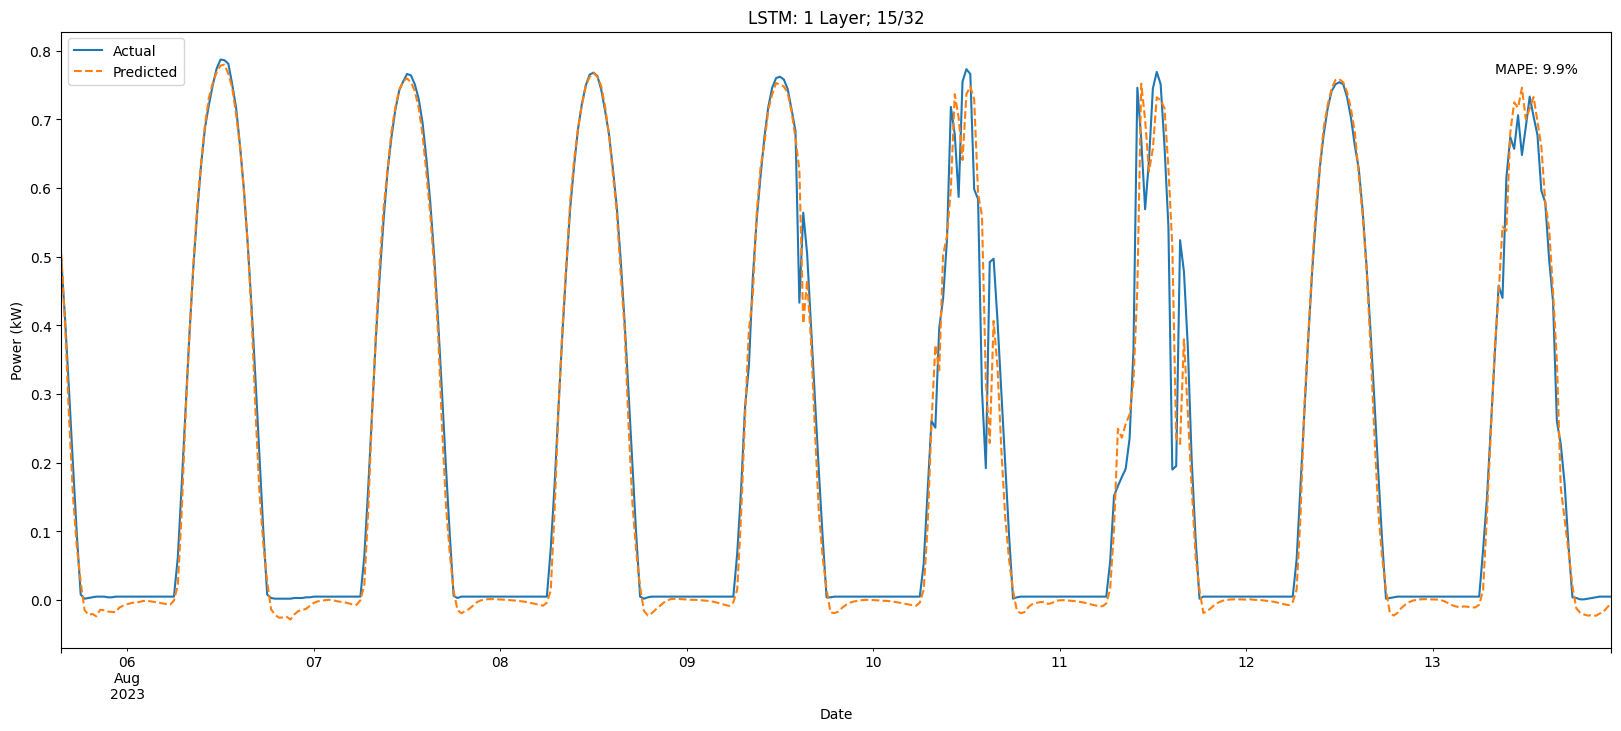

In [30]:
# Plot the data
_ = with_predicts[1700:2100].plot(x='Datetime', y=['Pac', 'Predictions'], figsize=(20,8), title="LSTM: 1 Layer; 15/32", style=['-','--'])

# Add y-axis label
plt.ylabel('Power (kW)')

# Add x-axis label
plt.xlabel('Date')
plt.legend(['Actual', 'Predicted'])

# Display the error value
plt.text(0.925, 0.95, f"MAPE: {error:.1f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.show()
